# **Superconductivity Regression Notebook - Testing Single Models**
Trains models to predict critical temperatures based on features found with "*../code/get_featurizers.ipynb*". Imports data from "*../data/supercon_feat.csv*", which is produced in *get_featurizers.ipynb*. The orginal data is from the supercon database. This notebook is for testing single models.

*Author: Kirk Kleinsasser*

In [1]:
import dill
#dill.load_session('../data/latest-run.db') #this can load a saved python session so I don't need to rerun computationally expensive cells
%autosave 300 
#autosaves code every five minutes

Autosaving every 300 seconds


## Import Libraries / Define Import Data Function

In [11]:
#general imports:
import warnings #to suppress grid search warnings
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns #heatmaps

#regression models:
from mlens.ensemble import SuperLearner
from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import AdaBoostRegressor, BaggingRegressor, ExtraTreesRegressor, RandomForestRegressor
from sklearn.linear_model import LinearRegression, LogisticRegression, Ridge, Lasso, ElasticNet, SGDRegressor, BayesianRidge
from sklearn.svm import SVR
from xgboost import XGBRegressor

#various ML tools:
from sklearn.pipeline import make_pipeline, Pipeline
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, StandardScaler
from sklearn.model_selection import train_test_split, GridSearchCV, KFold, cross_val_predict, cross_val_score
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error, max_error
from skopt import BayesSearchCV #bayesian optimization

#imports the data from get_featurizers. Function because some models we may want infinity:
def import_data(replace_inf=False):
    global data, target, train_data, test_data, train_target, test_target #variables that we want to define globally (outside of this funtion)
    data = pd.DataFrame(pd.read_csv('../data/supercon_features.csv')) #loads data produced in get_featurizer.ipynb
    target = data.pop('Tc') #remove target (critical temp) from data

    if replace_inf: #replaces values of infinity with NaN if replace_inf is True
        data.replace([np.inf, -np.inf], np.nan, inplace=True) 

    #TODO: debug feaurizers - NaN is entered when there is an error in the featurizer
    data.drop(['name','Unnamed: 0', 'composition'], axis=1, inplace=True) #drop columns irrelevant to training
    data = data[data.columns[data.notnull().any()]] #drop columns that are entirely NaN (12 columns) 

    for col in data: #replaces NaN with zeros
        data[col] = pd.to_numeric(data[col], errors ='coerce').fillna(0).astype('float')

    #creates a test train split, with shuffle and random state for reproducibility 
    train_data, test_data, train_target, test_target = train_test_split(data, target, test_size=0.15, random_state=43, shuffle=True)

## Evaluation Functions
To train models and return results

In [12]:
def evaluate_one(model_name, regressor, parameters): #define function that trains a model and prints scores and plots
    global train_data, train_data, test_data, test_target #we need these variables and don't want to pass them as arguments
    with plt.rc_context({'xtick.color':'white', 'ytick.color':'white','axes.titlecolor':'white','figure.facecolor':'#1e1e1e','text.color':'white','legend.labelcolor':'black'}):
        plt.title(f"{model_name} - Prediction vs. Actual Value (CV)", color='white')
        model = regressor(**parameters) #unpacks model and params
        model.fit(train_data.values, train_target.values) #fit the model
        model_pred = model.predict(test_data) #make predictions on test data

        mse = round(mean_squared_error(test_target, model_pred),3) #find mean square error
        mae = round(mean_absolute_error(test_target, model_pred),3) #find mean square error
        mxe = round(max_error(test_target, model_pred),3)
        r_squared = round(r2_score(test_target, model_pred),3) #find r2 score

        #make our plot - with plt.rc_context sets theme to look good in dark mode
        difference = np.abs(test_target - model_pred) #function that finds the absolute difference between predicted and actual value
        im = plt.scatter(model_pred, test_target, cmap='plasma_r', norm=plt.Normalize(0, 120), c=difference, label="Critical Temperature (K)") #create scatter plot of data 
        plt.plot((0,135), (0,135), 'k--', alpha=0.75) #add expected line. Values must be changed with different data to look good
        plt.title(model_name, c='white')
        plt.ylabel('Prediction', c='white')
        plt.xlabel('Actual Value', c='white')
        plt.annotate(f'R2: {r_squared}', xy = (0, -0.15), xycoords='axes fraction', ha='left', va="center", fontsize=10) #add footnote with R2 
        plt.annotate(f'MXE: {mxe}', xy = (0, -0.20), xycoords='axes fraction', ha='left', va="center", fontsize=10) #add footnote with R2 
        plt.annotate(f'MAE: {mae}', xy = (1.0, -0.20), xycoords='axes fraction', ha='right', va="center", fontsize=10) #add footnote with MAE
        plt.annotate(f'MSE: {mse}', xy = (1.0, -0.15), xycoords='axes fraction', ha='right', va="center", fontsize=10) #add footnote with MSE
        plt.legend()
        plt.colorbar().set_label(label="Difference from Actual (K)", color='white') #using .set_label() as colorbar() does accept color arguments
        plt.show()

## Linear Regression

In [4]:
import_data(replace_inf=True) #reimport data without infinities

linear = LinearRegression()
linear.fit(train_data, train_target)
linear_pred = linear.predict(test_data)

mse = mean_squared_error(test_target, linear_pred)
r_squared = r2_score(test_target, linear_pred)

print("MSE:", mse)
print("R2 :", r_squared)

MSE: 442.16314939573556
R2 : 0.3918631341771974


## Support Vector Regression

In [5]:
svr = SVR(kernel='rbf', C=100, epsilon=0.1, gamma=0.1, degree=1)
svr.fit(train_data, train_target)
svr_pred = svr.predict(test_data)

mse = mean_squared_error(test_target, svr_pred)
r_squared = r2_score(test_target, svr_pred)

print("MSE:", mse)
print("R2 :", r_squared)

MSE: 267.72718623518745
R2 : 0.6317767046957012


In [6]:
svr = SVR(C=1, epsilon=10, gamma='auto', kernel='linear')
svr.fit(train_data, train_target)
svr_pred = svr.predict(test_data)

mse = mean_squared_error(test_target, svr_pred)
r_squared = r2_score(test_target, svr_pred)

print("MSE:", mse)
print("R2 :", r_squared)

MSE: 490.66103295659246
R2 : 0.32516071687253356


## Elastic Net Regressor

In [21]:
elastic = ElasticNet()
elastic.fit(train_data, train_target)
elastic_pred = elastic.predict(test_data)

mse = mean_squared_error(test_target, elastic_pred)
r_squared = r2_score(test_target, elastic_pred)

print("Unoptimized Scores:")
print("MSE:", mse)
print("R2 :", r_squared)

elastic = ElasticNet(alpha=1e-05, l1_ratio=0.0)
elastic.fit(train_data, train_target)
elastic_pred = elastic.predict(test_data)

mse = mean_squared_error(test_target, elastic_pred)
r_squared = r2_score(test_target, elastic_pred)

print("\nOptimized Scores:")
print("MSE:", mse)
print("R2 :", r_squared)

Unoptimized Scores:
MSE: 488.2415548783691
R2 : 0.32848838860960294

Optimized Scores:
MSE: 442.13293825295574
R2 : 0.39190468560387814


## Descision Tree Regressor

In [22]:
dt = DecisionTreeRegressor()
dt.fit(train_data, train_target)
dt_pred = dt.predict(test_data)

mse = mean_squared_error(test_target, dt_pred)
r_squared = r2_score(test_target, dt_pred)

print("Unoptimized Scores:")
print("MSE:", mse)
print("R2 :", r_squared)

dt = DecisionTreeRegressor(criterion='poisson', max_depth=5, max_features=0.5)
dt.fit(train_data, train_target)
dt_pred = dt.predict(test_data)

mse = mean_squared_error(test_target, dt_pred)
r_squared = r2_score(test_target, dt_pred)

print("\nOptimized Scores:")
print("MSE:", mse)
print("R2 :", r_squared)

Unoptimized Scores:
MSE: 241.94759012509175
R2 : 0.6672331257068063

Optimized Scores:
MSE: 323.58942186541566
R2 : 0.5549455962226226


## Random Forest Regressor

In [23]:
rfr = RandomForestRegressor()
rfr.fit(train_data, train_target)
rfr_pred = rfr.predict(test_data)

mse = mean_squared_error(test_target, rfr_pred)
r_squared = r2_score(test_target, rfr_pred)

print("Unoptimized Scores:")
print("MSE:", mse)
print("R2 :", r_squared)

rfr = RandomForestRegressor(max_depth=80, max_features=3, min_samples_leaf=3, min_samples_split=8, n_estimators=500, n_jobs=-1)
rfr.fit(train_data, train_target)
rfr_pred = rfr.predict(test_data)

mse = mean_squared_error(test_target, rfr_pred)
r_squared = r2_score(test_target, rfr_pred)

print("\nOptimized Scores:")
print("MSE:", mse)
print("R2 :", r_squared)

Unoptimized Scores:
MSE: 143.39198810743505
R2 : 0.8027833066800633

Optimized Scores:
MSE: 152.654530627431
R2 : 0.7900439058834144


## KNeighbors Regressor

In [24]:
knn = KNeighborsRegressor()
knn.fit(train_data, train_target)
knn_pred = knn.predict(test_data)

mse = mean_squared_error(test_target, knn_pred)
r_squared = r2_score(test_target, knn_pred)

print("Unoptimized Scores:")
print("MSE:", mse)
print("R2 :", r_squared)

knn = KNeighborsRegressor(metric='manhattan', n_jobs=-1, n_neighbors=8)
knn.fit(train_data, train_target)
knn_pred = knn.predict(test_data)

mse = mean_squared_error(test_target, knn_pred)
r_squared = r2_score(test_target, knn_pred)

print("\nOptimized Scores:")
print("MSE:", mse)
print("R2 :", r_squared)

Unoptimized Scores:
MSE: 257.2219705167492
R2 : 0.6462252379362805

Optimized Scores:
MSE: 224.46649138793268
R2 : 0.6912760623732452


## Extra Trees Regressor

In [25]:
trees = ExtraTreesRegressor()
trees.fit(train_data, train_target)
trees_pred = trees.predict(test_data)

mse = mean_squared_error(test_target, trees_pred)
r_squared = r2_score(test_target, trees_pred)

print("Unoptimized Scores:")
print("MSE:", mse)
print("R2 :", r_squared)

trees = ExtraTreesRegressor(min_samples_leaf=1.0, min_samples_split=0.1, n_estimators=250, n_jobs=-1)
trees.fit(train_data, train_target)
trees_pred = trees.predict(test_data)

mse = mean_squared_error(test_target, trees_pred)
r_squared = r2_score(test_target, trees_pred)

print("\nOptimized Scores:")
print("MSE:", mse)
print("R2 :", r_squared)

Unoptimized Scores:
MSE: 132.8607595327332
R2 : 0.8172676171601091

Optimized Scores:
MSE: 727.091786219976
R2 : -1.847879361971394e-05


## Stochastic Gradient Descent

In [27]:
sgd = SGDRegressor()
sgd.fit(train_data, train_target)
sgd_pred = sgd.predict(test_data)

mse = mean_squared_error(test_target, sgd_pred)
r_squared = r2_score(test_target, sgd_pred)

print("Unoptimized Scores:")
print("MSE:", mse)
print("R2 :", r_squared)

sgd = SGDRegressor(alpha=1000.0, loss='epsilon_insensitive', max_iter=1500, penalty='l1')
sgd.fit(train_data, train_target)
sgd_pred = sgd.predict(test_data)

mse = mean_squared_error(test_target, sgd_pred)
r_squared = r2_score(test_target, sgd_pred)

print("\nOptimized Scores:")
print("MSE:", mse)
print("R2 :", r_squared)

Unoptimized Scores:
MSE: 1.5627072578980882e+28
R2 : -2.1492969174736365e+25

Optimized Scores:
MSE: 892.9276043163728
R2 : -0.22810368850891805


## Bayesian Regression

In [28]:
bayes = BayesianRidge()
bayes.fit(train_data, train_target)
bayes_pred = bayes.predict(test_data)

mse = mean_squared_error(test_target, bayes_pred)
r_squared = r2_score(test_target, bayes_pred)

print("Unoptimized Scores:")
print("MSE:", mse)
print("R2 :", r_squared)

bayes = BayesianRidge(alpha_init=1.2, lambda_init=0.0001)
bayes.fit(train_data, train_target)
bayes_pred = bayes.predict(test_data)

mse = mean_squared_error(test_target, bayes_pred)
r_squared = r2_score(test_target, bayes_pred)

print("\nOptimized Scores:")
print("MSE:", mse)
print("R2 :", r_squared)

Unoptimized Scores:
MSE: 441.9254330396055
R2 : 0.39219008154938184

Optimized Scores:
MSE: 441.9254330462792
R2 : 0.3921900815402031


## Superlearner

In [5]:
import_data(replace_inf=True)
# create a list of base-models
def get_models():
	models = list()
	models.append(SVR())
	models.append(SVR())
	models.append(ElasticNet(alpha=1e-05, l1_ratio=0.0))
	models.append(DecisionTreeRegressor())
	models.append(RandomForestRegressor())
	models.append(KNeighborsRegressor(metric='manhattan', n_jobs=-1, n_neighbors=8))
	# models.append(ExtraTreesRegressor())
	# models.append(SGDRegressor(alpha=1000.0, loss='epsilon_insensitive', max_iter=1500, penalty='l1'))
	# models.append(BayesianRidge(alpha_init=1.2, lambda_init=0.0001))

	return models

In [6]:
def get_super_learner(X):
	ensemble = SuperLearner(scorer=r2_score, folds=10, shuffle=True, sample_size=len(X))
	# add base models
	models = get_models()
	ensemble.add(models)
	# add the meta model
	ensemble.add_meta(LinearRegression())

	return ensemble
ensemble = get_super_learner(train_data)

In [13]:
warnings.filterwarnings('ignore') #got tired of non-converging erros

#fit the super learner
ensemble.fit(train_data.values,train_target.values)
#summarize base learners
print(ensemble.data)

train_pred = ensemble.predict(train_data)
test_pred = ensemble.predict(test_data)

#obtain scores for the model
training_r2 = r2_score(train_target,train_pred)
test_r2 = r2_score(test_target,test_pred)

training_mse = mean_squared_error(train_target,train_pred)
test_mse = mean_squared_error(test_target,test_pred)

print("\nTraining R2",training_r2,"\nCV R2",test_r2)
print("\nTraining MSE",training_mse,"\nCV MSE",test_mse)

                                  score-m  score-s   ft-m  ft-s  pt-m  pt-s
layer-1  decisiontreeregressor       0.64     0.04   0.79  0.06  0.00  0.00
layer-1  elasticnet                  0.39     0.02   3.33  0.37  0.00  0.00
layer-1  kneighborsregressor         0.69     0.03   0.01  0.01  0.90  0.21
layer-1  randomforestregressor       0.81     0.02  55.37  1.15  0.11  0.03
layer-1  svr-1                       0.08     0.01  46.91  9.30  4.79  0.90
layer-1  svr-2                       0.08     0.01  42.46  4.84  3.12  1.18


Training R2 0.9735048398241802 
CV R2 0.8072191668873687

Training MSE 19.297083953007263 
CV MSE 140.16677018401958


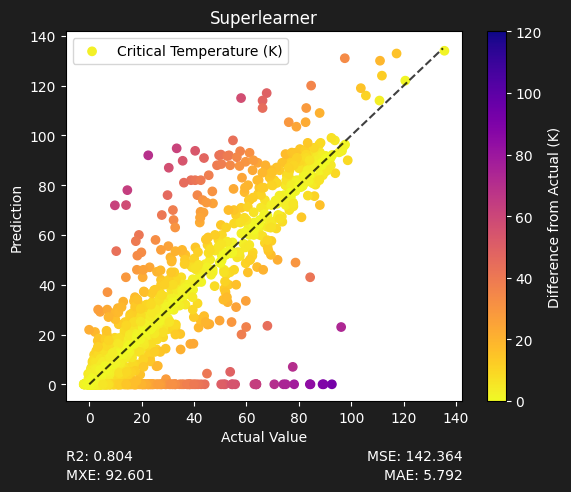

In [14]:
evaluate_one("Superlearner", get_super_learner, {'X': train_data})

In [16]:
dill.dump_session('../data/supercon_ml_latest_run.db') #this can dump a python session so I can resume later, after restarts and such